# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import diffrax as dfx
from functools import partial
import dynesty
from dynesty import plotting as dyplot
import matplotlib.pyplot as plt
import seaborn as sns

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


root_dir = '..'

In [3]:
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from bioreaction.simulation.manager import simulate_steady_states



# Simulation

In [4]:

def scale_rates(forward_rates, reverse_rates, cushioning: int = 4):
    rate_max = np.max([np.max(np.asarray(forward_rates)),
                        np.max(np.asarray(reverse_rates))])

    dt0 = 1 / (cushioning * rate_max)
    return dt0

In [5]:
def optimise_sp(s, p):
    s_lin = 1 / p
    return s - s_lin

In [6]:
def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


def dummy_simfunc(
        y0, t0, t1, dt0,
        forward_rates,
        reverse_rates,
        inputs,
        outputs,
        threshold = 0.01
        # max_steps,
        # signal=vanilla_return, signal_onehot=1
    ):
    steps = int((t1 - t0) / dt0)
    y = np.zeros((steps, len(y0.squeeze())))
    time = np.arange(t0, t1, dt0)
    y[0] = y0
    for t in range(1, steps):
        yt = one_step_de_sim_expanded(
            spec_conc=y[t-1], inputs=inputs,
            outputs=outputs,
            forward_rates=forward_rates,
            reverse_rates=reverse_rates)
        y[t] = y[t-1] + yt * dt0
        if np.sum((np.abs(yt) - threshold ) * dt0) < 0:
            return y[:t], time[:t]
    return y, time

In [7]:
def compute_analytics(y, t, labels, signal_onehot):
    y = np.swapaxes(y, 0, 1)
    
    analytics_func = partial(
        generate_analytics, time=t, labels=labels,
        signal_onehot=signal_onehot, signal_time=0,
        ref_circuit_data=None)
    return analytics_func(data=y, time=t, labels=labels)

In [8]:

def make_piecewise_stepcontrol(t0, t1, dt0, dt1, split: int = 3):
    tdiff = (t1 - t0) / split
    dts = np.interp(np.arange(split), [0, split-1], [dt0, dt1])

    i = 0
    ts = np.arange(
            t0 + tdiff * i, 
            t0 + tdiff * i + tdiff, 
            dts[i])
    for i in range(i+1, split):
        nx = np.arange(
            t0 + tdiff * i, 
            t0 + tdiff * i + tdiff, 
            dts[i])
        ts = np.concatenate([ts, nx])
    ts[0] = t0
    ts[-1] = t1
    return dfx.StepTo(ts)

In [9]:
def R(B11, B12, B13, B22, B23, B33):
    unbound_species = ['RNA_0', 'RNA_1', 'RNA_2']
    species = ['RNA_0', 'RNA_1', 'RNA_2', 'RNA_0-0', 'RNA_0-1', 'RNA_0-2', 'RNA_1-1', 'RNA_1-2', 'RNA_2-2']
    signal_species = ['RNA_0']
    output_species = ['RNA_1']
    s_idxs = [species.index(s) for s in signal_species]
    output_idxs = [species.index(s) for s in output_species]
    signal_onehot = np.array([1 if s in [species.index(ss) for ss in signal_species] else 0 for s in np.arange(len(species))])
    
    signal_target = 2
    k = 0.00150958097
    N0 = 200
    
    # Amounts
    y00 = np.array([[N0, N0, N0, 0, 0, 0, 0, 0, 0]])
    
    # Reactions
    inputs = np.array([
        [2, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0, 0, 0, 0],
    ])
    outputs = np.array([
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
    ])
    
    # Rates
    reverse_rates = np.array([[B11, B12, B13, B22, B23, B33]])
    forward_rates = np.ones_like(reverse_rates) * k
    
    # Sim params
    t0 = 0
    t1 = 100
    # dt0 = scale_rates(forward_rates, reverse_rates, cushioning=4)
    dt0 = 0.0005555558569638981
    dt1_factor = 5
    dt1 = dt0 * dt1_factor
    max_steps = 16**4 * 10
    # print('\n\nInput N:', y00)
    # print('Input B:', reverse_rates)
    sim_func = jax.jit(partial(bioreaction_sim_dfx_expanded,
        t0=t0, t1=t1, dt0=dt0,
        signal=vanilla_return, signal_onehot=1,
        forward_rates=forward_rates,
        inputs=inputs,
        outputs=outputs,
        solver=dfx.Tsit5(),
        saveat=dfx.SaveAt(
            ts=np.linspace(t0, t1, 500)),  # int(np.min([500, self.t1-self.t0]))))
        max_steps=max_steps,
        stepsize_controller=make_piecewise_stepcontrol(t0=t0, t1=t1, dt0=dt0, dt1=dt1)
        ))
    
    y0, t = simulate_steady_states(y0=y00, total_time=t1-t0, sim_func=sim_func, t0=t0, t1=t1, threshold=0.1, reverse_rates=reverse_rates, disable_logging=True)
    y0 = np.array(y0.squeeze()[-1, :]).reshape(y00.shape)
    
    # Signal
    
    y0s = y0 * ((signal_onehot == 0) * 1) + y00 * signal_target * signal_onehot
    y, t = simulate_steady_states(y0s, total_time=t1-t0, sim_func=sim_func, t0=t0, t1=t1, threshold=0.1, reverse_rates=reverse_rates, disable_logging=True)
    y = np.concatenate([y0, y.squeeze()[:-1, :]], axis=0)
    # y1 = np.array(y[-1, :])
        
    # print('Output:', y1)
    
    analytics = compute_analytics(y, t, labels=np.arange(y.shape[-1]), signal_onehot=signal_onehot)
    
    s = analytics['sensitivity_wrt_species-0']
    p = analytics['precision_wrt_species-0']
    # print(f'Sensitivity {output_idxs[0]}:', s[tuple(output_idxs)])
    # print(f'Precision {output_idxs[0]}:', p[tuple(output_idxs)])
    
    r = optimise_sp(
        s=s.squeeze()[tuple(output_idxs)], p=p.squeeze()[tuple(output_idxs)]
    )
    
    return r

### Check that R is working

In [10]:

dummy_B = np.array([0.000164, 899.999500, 0.000114, 899.999500, 899.9995, 899.9995], dtype=np.float64)

dummy_B = np.array([8.9999950e+02, 1.1106876e-01, 8.9999950e+02, 2.4811807e-04, 8.9999950e+02, 1.9628435e+00])

dummy_B = np.array([899.9995,0.11106876,899.9995,0.00024811807,899.9995,1.9628435])
# Min sensitivity:
# toy_mRNA_circuit_11232	RNA_2_m15-0
# For [0.000164, 899.999500, 0.000114, 899.999500, 899.9995, 899.9995] :
# s = 2.442697e-07

r = R(*dummy_B)

2023-08-17 12:10:49.140987: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# Log likelihood

Let's first create a realistic sampler of binding rates of dissociation. See explanation notebook 5, 'examine binding energies'.

In [12]:

# og_dir = '../data/ensemble_mutation_effect_analysis/2023_07_15_192831/generate_species_templates'
# fn = os.path.join(og_dir, 'circuit_stats.csv')
# fn = '../data/generate_seqs_flexible/2023_04_17_205800/circuit_stats.csv'
# data = pd.read_csv(fn)

fn = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
datam = data.melt(['circuit_name', 'mutation_name'], value_vars=get_true_interaction_cols(data, 'binding_rates_dissociation', remove_symmetrical=True), var_name='idx', value_name='binding_rates_dissociation')

In [13]:
def sample_distribution(u, norm_dist, rate_dist):
    return np.interp(u, norm_dist, rate_dist)

rates=datam['binding_rates_dissociation'].to_numpy()
hist, bin_edges = np.histogram(rates, bins=120)
norm_dist = np.cumsum(hist) / np.sum(hist)
norm_dist = np.concatenate([[0], norm_dist])
rate_dist = bin_edges

sample_distribution = partial(sample_distribution, norm_dist=norm_dist, rate_dist=rate_dist)

Text(0.5, 1.0, 'Synthetic mimic distribution')

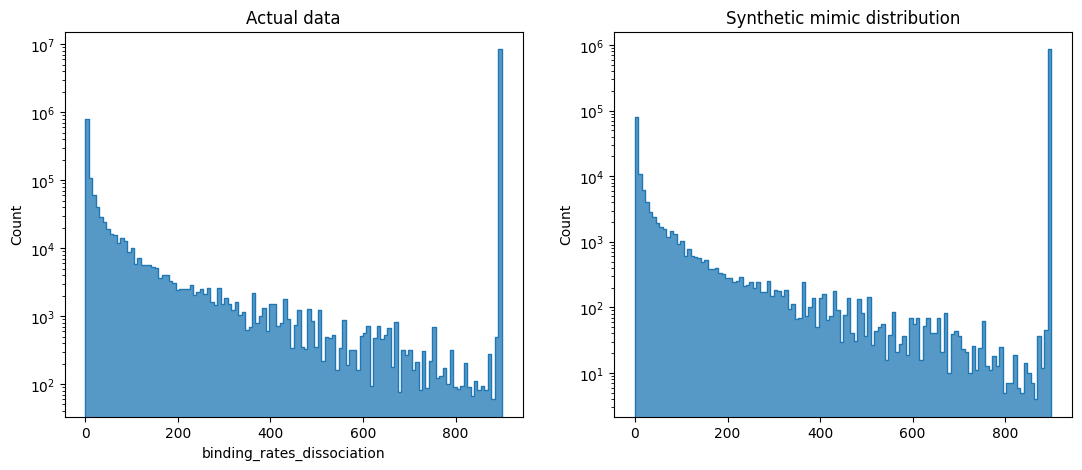

In [14]:
plt.figure(figsize=(13, 5))
ax = plt.subplot(1,2,1)
sns.histplot(datam, x='binding_rates_dissociation', log_scale=[False, True], element='step', bins=120)
plt.title('Actual data')

ax = plt.subplot(1,2,2)
sns.histplot(sample_distribution(np.random.rand(1000000)), element='step', bins=120, log_scale=[False, True])
plt.title('Synthetic mimic distribution')

In [ ]:
stop

There's too much of a bias towards the non-functional rate 899 at the right edge of the distribution. Let's just get rid of that last bin entirely.

In [19]:

hist, bin_edges = hist[:-1], bin_edges[:-1]
norm_dist = np.cumsum(hist) / np.sum(hist)
norm_dist = np.concatenate([[0], norm_dist])
rate_dist = bin_edges

sample_distribution = partial(sample_distribution, norm_dist=norm_dist, rate_dist=rate_dist)


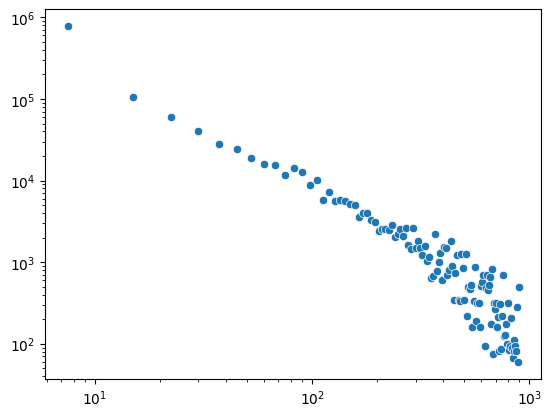

In [20]:
sns.scatterplot(x=list(bin_edges)[1:], y=hist[:])
plt.xscale('log')
plt.yscale('log')


## Actual log likelihood

In [21]:
ndim = 6

def loglike(B):
    
    L = - 1 / (R(*B) + 0.0001)
    
    print(L)
    
    return L


def ptform(u, distribution):
    # R_max = 1
    # R_min = 0.00001
    # x = R_max * u + R_min
    x = distribution(u)
    
    return x

# Sampling

In [22]:

sampler = dynesty.NestedSampler(loglike, partial(ptform, distribution=sample_distribution), ndim)
sampler.run_nested(maxiter=500)
sresults = sampler.results

# fig, axes = plt.subplots(6, 13, figsize=(25, 10))
# axes = axes.reshape((6, 13))  # reshape axes

# # add white space
# [a.set_frame_on(False) for a in axes[:, 6]]
# [a.set_xticks([]) for a in axes[:, 6]]
# [a.set_yticks([]) for a in axes[:, 6]]

# # plot initial run (res1; left)
# fg, ax = dyplot.cornerpoints(sresults, cmap='plasma', truths=np.zeros(ndim),
#                              kde=False, fig=(fig, axes[:, :2]))

-235.89912
-141.32195
-259.32315
-10000.0
-510.1916
-10000.0
-56.01087
-82.156685
-9999.628
-1792.3832
-5134.139
-139.55084
-39.928547
-107.33565
-174.90604
-1384.553
-337.35873
-692.9405
-3993.0276
-513.0468
-432.27884
-1183.7273
-10000.0
-116.69454
-867.1909
-50.420628
-10000.0
-14.423977
-10000.0
-2469.1316
-2283.516
-10000.0
-4969.168
-10000.0
-104.378395
-1299.8795
-4010.1326
-326.292
-709.4925
-8061.1133
-479.07593
-549.27606
-10000.0
-170.2187


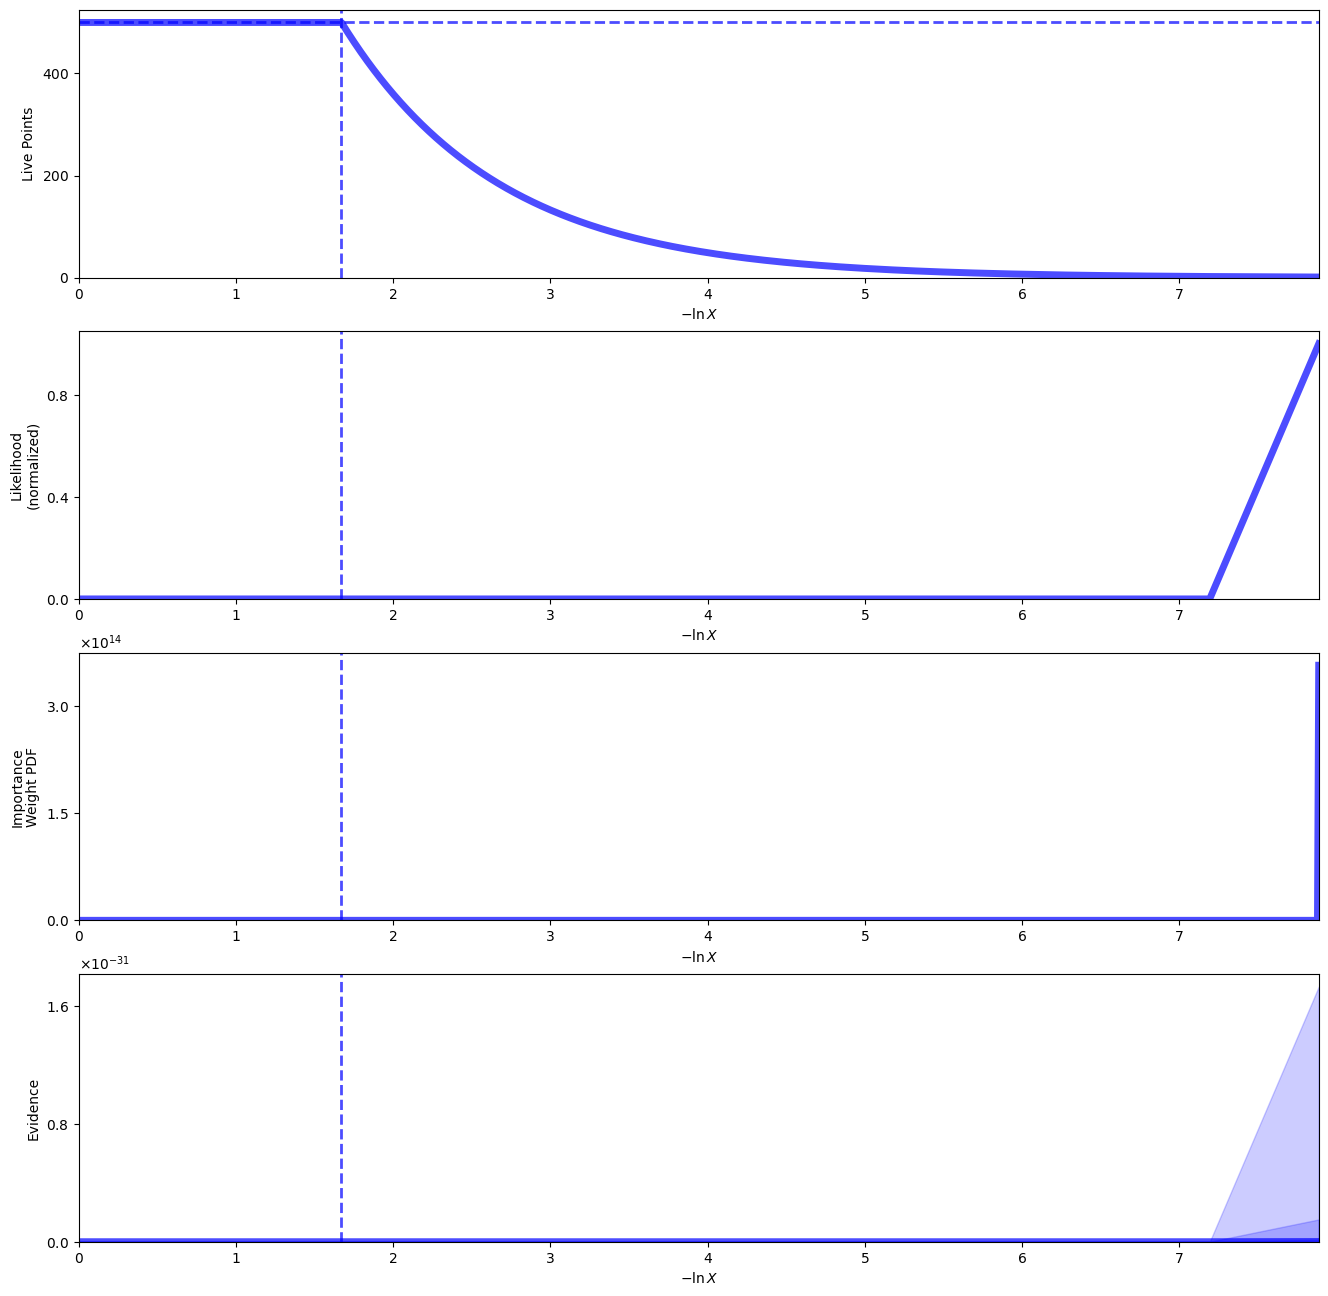

In [ ]:

rfig, raxes = dyplot.runplot(sresults)
rfig.savefig('test.png')

/usr/local/lib/python3.10/dist-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])


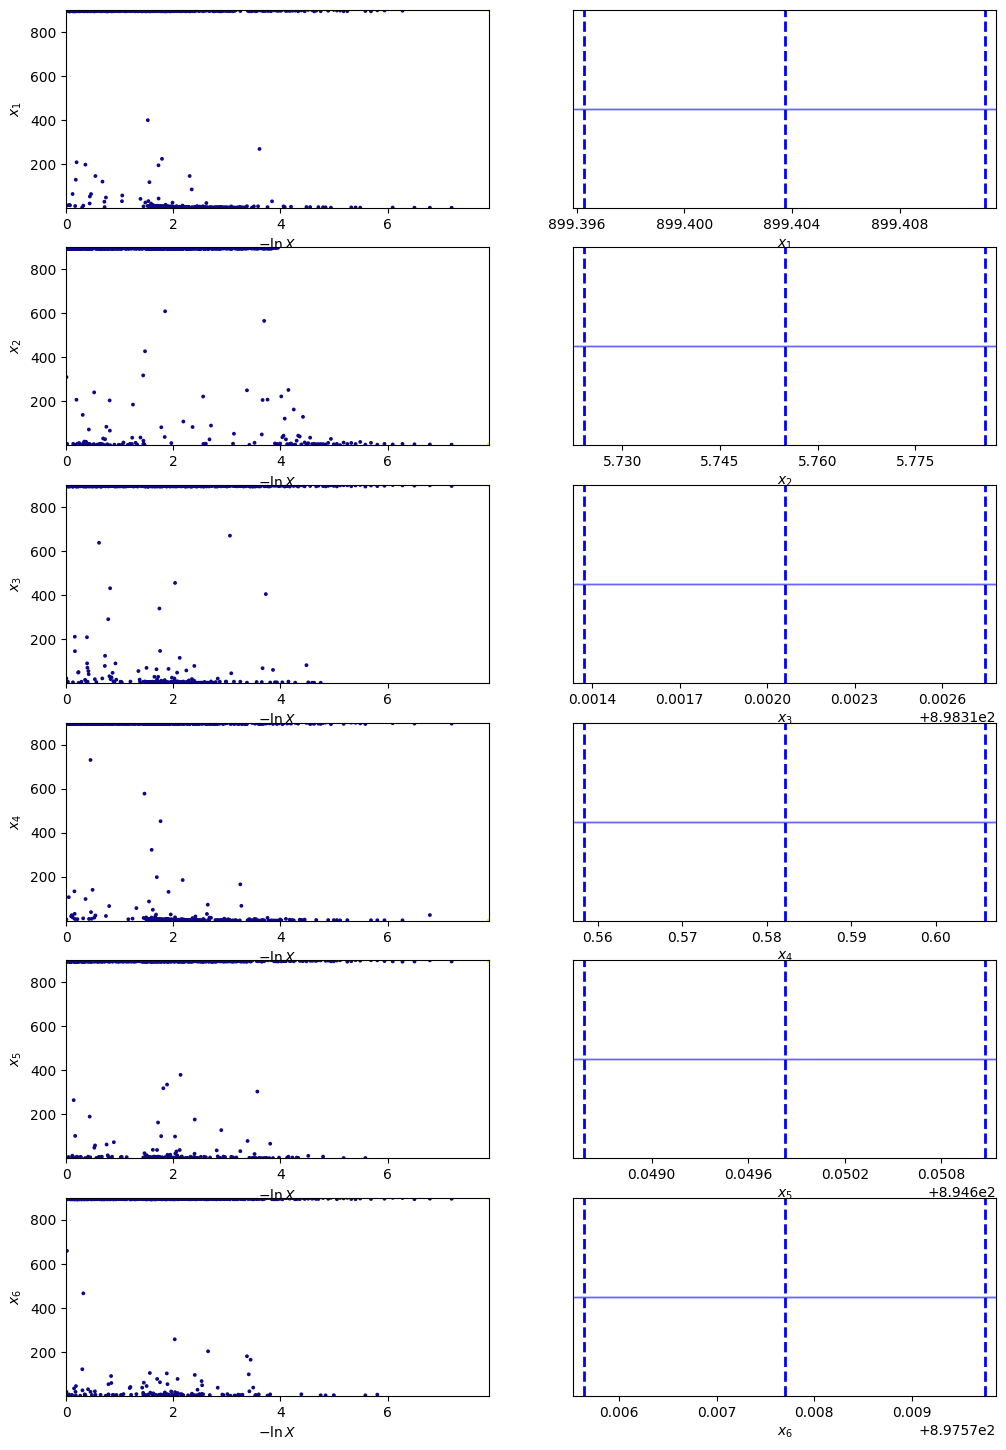

In [ ]:

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(sresults)

/usr/local/lib/python3.10/dist-packages/dynesty/plotting.py:1368: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(n) * 1.05])
/usr/local/lib/python3.10/dist-packages/dynesty/plotting.py:2310: RuntimeWarning: invalid value encountered in divide
  sm /= sm[-1]


ValueError: Contour levels must be increasing

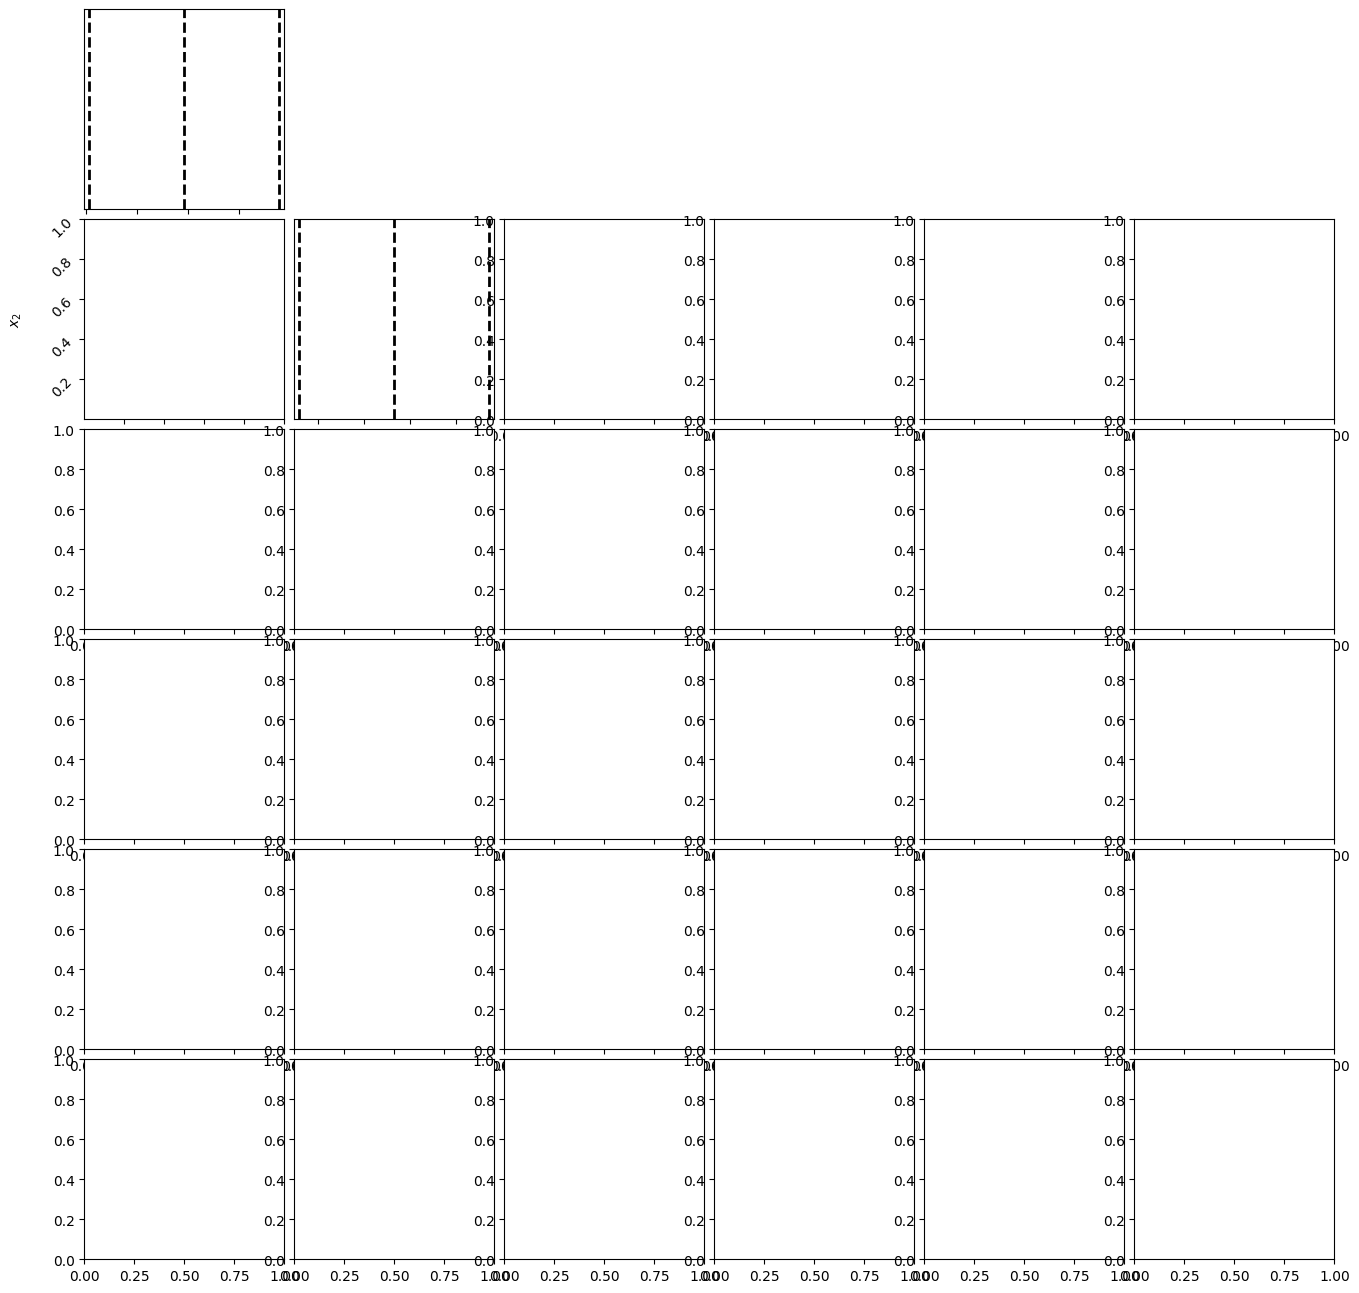

In [ ]:

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(sresults)